In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osgeo.gdal
from rasterstats import zonal_stats
import rioxarray as rxr
import rasterio as rio
from affine import Affine

import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
fire_path = 'data/Fire_Districts/Fire_Districts.shp'


In [3]:
heat_gdf = gpd.read_file('data/Mesonet/daily_temp.gpkg', layer='temps')
heat_gdf['date_time'] = pd.to_datetime(heat_gdf['date_time'])
district_gdf = gpd.read_file(fire_path)

## Begin Looping Code

In [16]:
def InterpolateTemp(temp_gdf:gpd.GeoDataFrame, district_shapes:gpd.GeoDataFrame, date:str, col:str):
    """
    Takes in the the temperature dataframe, fire districts, date to slice by and column to interpolate
    Returns geodataframe in shape of districts_shapes with interpolated mean data for date and col

    temp_gdf --> Geodataframe of weatherstations with data
    districts_shapes --> GeoDataFrame of districts to interpolate to
    date --> date to slice temp_gdf by
    col --> column to interpolate in temp_gdf
    """
    bounds = district_shapes.total_bounds
    temp_station_path = 'data/working/temp_data.shp'
    temp_raster_path = 'data/working/temp_raster.tiff'
    temp_gdf = temp_gdf[['date_time', col, 'geometry']]
    temp_gdf.rename(columns={col:'z_col'}, inplace=True)
    temp_gdf['date_time'] = temp_gdf['date_time'].astype(str) #avoids shapefile error with processing datetime types
    temp_gdf[temp_gdf['date_time']==date].to_file('data/working/temp_data.shp') # slice data by date and create shapefile for interpolating

    rasterDs = osgeo.gdal.Grid(
        temp_raster_path,
        temp_station_path,
        format='GTiff',
        zfield='z_col',
        outputBounds=bounds,
        algorithm='invdist',
    )
    
    rasterDs = None
    del rasterDs

    ### For some reason GDAL creates a raster with unexpected affine transform that begins in lower left corner
    ### we must create an affine transorm with a negative cell height and flip the array to read the data properly for zonal stats

    af = Affine(0.002003195255464829, 0.0, -118.66818799560865,
       0.0, -0.002475198135987511, 34.33730781636643)
    
    
    with rio.open(temp_raster_path) as src:
    # Read the raster data as an array
        raster_array = src.read(1)
        
        # Flip the array vertically
        flipped_array = np.flip(raster_array, axis=0)
        
        # Update the metadata of the raster
        kwargs = src.meta.copy()
        
        # Write the flipped raster to a new file
        with rio.open(temp_raster_path, 'w', **kwargs) as dst:
            dst.write(flipped_array, 1)
            dst.transform = af
        
    data = rio.open(temp_raster_path)
    stats = pd.DataFrame(zonal_stats(district_shapes, data.read(1), affine=af, stats=['mean']))
    stats_gdf = district_shapes.join(stats)
    stats_gdf.rename(columns={'mean':col}, inplace=True)
    stats_gdf['date_time'] = date

    return stats_gdf



In [7]:
heat_gdf.head()

,date_time,stid,relative_humidity_high,air_temp_high,heat_index_high,relative_humidity_low,air_temp_low,heat_index_low,lon,lat,geometry
0,2018-01-01,KBUR,100.00,73.94,72.12299,22.35,44.6,42.07209,-118.36538,34.19967,POINT (-118.36538 34.19967)
1,2018-01-02,KBUR,82.14,80.96,79.29248,12.73,51.8,49.59400,-118.36538,34.19967,POINT (-118.36538 34.19967)
2,2018-01-03,KBUR,52.30,75.20,74.11247,16.05,53.6,50.30359,-118.36538,34.19967,POINT (-118.36538 34.19967)
3,2018-01-04,KBUR,50.37,75.20,74.23091,18.57,51.8,49.03376,-118.36538,34.19967,POINT (-118.36538 34.19967)
4,2018-01-05,KBUR,93.65,73.40,73.11665,40.92,53.6,52.77579,-118.36538,34.19967,POINT (-118.36538 34.19967)


<ipython-input-16-631b30276114>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_gdf.rename(columns={col:'z_col'}, inplace=True)
/Users/seth/anaconda3/envs/cemo/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/seth/anaconda3/envs/cemo/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.In

<Axes: >

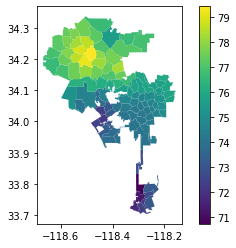

In [19]:
InterpolateTemp(heat_gdf, district_gdf, '2018-01-02', 'heat_index_high').plot(column = 'heat_index_high', legend = True)